**M3alem:Digital Twin For Moroccan Artisans**

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving all_landmarks_labeled.csv to all_landmarks_labeled.csv


# Sequencing

In [ ]:
import pandas as pd
import numpy as np

# Load the labeled landmarks file
df = pd.read_csv("all_landmarks_labeled.csv")

# Get unique gesture labels
labels = df["label"].unique()

# Parameters
sequence_length = 35
n_landmarks = 21
n_features = 3

sequences = []
sequence_labels = []

# Group data by gesture label
for label in labels:
    label_df = df[df["label"] == label]

    # Group by frame (so we group landmarks per frame)
    grouped = label_df.groupby("frame_name")

    frames = []
    for frame_name, group in grouped:
        group = group.sort_values("landmark_id")
        landmarks = group[["x", "y", "z"]].values.flatten()
        if len(landmarks) == n_landmarks * n_features:
            frames.append(landmarks)


    for i in range(len(frames) - sequence_length + 1):
        seq = frames[i:i + sequence_length]
        sequences.append(seq)
        sequence_labels.append(label)

# Convert to arrays
X = np.array(sequences)  # Shape: (num_sequences, 40, 63)
y = np.array(sequence_labels)  # Shape: (num_sequences,)

print(f"✅ Sequences created: {X.shape[0]}")
print(f"📐 Shape of one sequence: {X.shape[1:]} (frames, features)")


✅ Sequences created: 8059
📐 Shape of one sequence: (35, 63) (frames, features)


In [ ]:
np.save("X_sequences.npy", X)
np.save("y_labels.npy", y)


In [ ]:
print(np.isnan(X).sum())  # Should be 0
print(np.unique(y))       # Check label diversity


0
['joj_shoma' 'lmayla' 'nakhla' 'qbibat' 'sahm' 'sansla_sghira'
 'tbila_sghira' 'tbla_double' 'tbla_kbira' 'warda']


# Normalisation

In [ ]:
import numpy as np

def normalize_sequences(X):

    X_normalized = np.copy(X)
    num_sequences, seq_length, n_features = X.shape
    n_landmarks = 21

    for seq_i in range(num_sequences):
        for frame_i in range(seq_length):
            frame = X_normalized[seq_i, frame_i].reshape(n_landmarks, 3)  # shape (21,3)

            wrist = frame[0]  # wrist landmark coords (x,y,z)

            # Translate so wrist at origin
            frame -= wrist

            # Compute scale: distance wrist to middle finger tip (landmark 12)
            middle_finger_tip = frame[12]
            scale = np.linalg.norm(middle_finger_tip)

            # Avoid division by zero
            if scale > 1e-6:
                frame /= scale

            # Put back normalized frame
            X_normalized[seq_i, frame_i] = frame.flatten()

    return X_normalized

# Apply normalization
X_normalized = normalize_sequences(X)

print("Normalization done.")



Normalization done.


In [ ]:
import numpy as np
import os
from datetime import datetime

# 1. Create timestamped directory
save_dir = f"normalized_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(save_dir, exist_ok=True)

# 2. Save normalized data
np.save(os.path.join(save_dir, "X_normalized.npy"), X_normalized)
np.save(os.path.join(save_dir, "y_labels.npy"), y)  # Preserve original labels

# 3. Save normalization metadata
normalization_metadata = {
    "normalization_method": "wrist_centered_scaled",
    "reference_landmark": 0,  # Wrist
    "scale_reference": 12,    # Middle finger tip
    "original_shape": X.shape,
    "normalization_date": datetime.now().isoformat()
}



print(f"✅ Normalized data saved to {save_dir}/")
print(f"📁 Contents:")
print(f"- X_normalized.npy (shape: {X_normalized.shape})")
print(f"- y_labels.npy")


✅ Normalized data saved to normalized_data_20250528_130616/
📁 Contents:
- X_normalized.npy (shape: (8059, 35, 63))
- y_labels.npy


# Augmentation

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import random
from tqdm import tqdm  # Added missing import


def augment_sequence(sequence):
    """Apply three distinct augmentations to a single sequence"""
    aug1 = temporal_warp(sequence)  # Time distortion
    aug2 = spatial_jitter(sequence)  # Coordinate noise
    aug3 = axis_rotate(sequence)    # 3D rotation
    return [aug1, aug2, aug3]

def temporal_warp(sequence, warp_factor=0.3):
    """Non-linear time warping with cubic interpolation"""
    orig_steps = np.arange(sequence.shape[0])
    new_steps = orig_steps * (1 + warp_factor * np.random.uniform(-1, 1, size=orig_steps.shape))
    new_steps = np.clip(new_steps, 0, sequence.shape[0]-1)

    warped = np.zeros_like(sequence)
    for landmark in range(sequence.shape[1]):
        f = interp1d(orig_steps, sequence[:, landmark], axis=0, kind='cubic')
        warped[:, landmark] = f(new_steps)
    return warped

def spatial_jitter(sequence, noise_std=0.03):
    """Add Gaussian noise to landmarks (except wrist)"""
    jittered = sequence.copy()
    # Skip wrist (landmark 0) to maintain reference
    jittered[:, 1:] += np.random.normal(0, noise_std, size=jittered[:, 1:].shape)
    return jittered

def axis_rotate(sequence, max_angle=15):
    """Rotate around wrist joint (landmark 0)"""
    radians = np.radians(np.random.uniform(-max_angle, max_angle, 3))
    rot_mat = rotation_matrix(radians)

    centered = sequence - sequence[0]  # Center at wrist
    rotated = np.dot(centered.reshape(-1, 3), rot_mat).reshape(sequence.shape)
    return rotated + sequence[0]  # Restore wrist position

def rotation_matrix(angles):
    """Generate 3D rotation matrix from Euler angles"""
    cx, cy, cz = np.cos(angles)
    sx, sy, sz = np.sin(angles)

    return np.array([
        [cy*cz, -cy*sz, sy],
        [sx*sy*cz + cx*sz, -sx*sy*sz + cx*cz, -sx*cy],
        [-cx*sy*cz + sx*sz, cx*sy*sz + sx*cz, cx*cy]
    ])

# Main augmentation process
X_augmented = []
y_augmented = []

for i in tqdm(range(len(X_normalized)), desc="Augmenting"):
    # Reshape to (35, 21, 3)
    seq = X_normalized[i].reshape(35, 21, 3)
    augs = augment_sequence(seq)

    # Store all augmentations
    for aug in augs:
        X_augmented.append(aug.reshape(35, 63))
        y_augmented.append(y[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"\n✅ Augmentation complete. Dataset size tripled from {len(X_normalized)} to {len(X_augmented)}")
print(f"New shapes - X: {X_augmented.shape}, y: {y_augmented.shape}")

Augmenting: 100%|██████████| 8059/8059 [00:35<00:00, 227.31it/s]



✅ Augmentation complete. Dataset size tripled from 8059 to 24177
New shapes - X: (24177, 35, 63), y: (24177,)


In [ ]:
import numpy as np
import os
from datetime import datetime

# Create timestamped directory
save_dir = f"augmented_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(save_dir, exist_ok=True)

# Save arrays
np.save(os.path.join(save_dir, "X_augmented.npy"), X_augmented)
np.save(os.path.join(save_dir, "y_augmented.npy"), y_augmented)

In [ ]:
def load_augmented_data(path):
    """Quick loader for augmented data"""
    return (
        np.load(os.path.join(path, "X_augmented.npy")),
        np.load(os.path.join(path, "y_augmented.npy"))
    )

# Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Step 1: Convert strings to integers
label_encoder = LabelEncoder()
y_integer = label_encoder.fit_transform(y_augmented)

# Step 2: Convert integers to one-hot
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_integer.reshape(-1, 1))

# Verification
print("✅ Encoded labels shape:", y_onehot.shape)
print("Sample conversion:")
print("Original:", y_augmented[0], "→ Integer:", y_integer[0], "→ One-Hot:", y_onehot[0])

✅ Encoded labels shape: (24177, 10)
Sample conversion:
Original: sansla_sghira → Integer: 5 → One-Hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
import numpy as np

# Save the one-hot encoded labels
np.save("y_labels_onehot.npy", y_onehot)

# Save the label encoder classes for future reference
np.save("label_classes.npy", label_encoder.classes_)

print("💾 Saved files:")
print("- y_labels_onehot.npy: One-hot encoded labels (for model training)")
print("- label_classes.npy: Class name mapping (for interpretation)")

💾 Saved files:
- y_labels_onehot.npy: One-hot encoded labels (for model training)
- label_classes.npy: Class name mapping (for interpretation)


In [ ]:
# Check class-to-index mapping
class_mapping = {i: cls for i, cls in enumerate(label_encoder.classes_)}
print("\n🔠 Class Mapping:")
for idx, name in class_mapping.items():
    print(f"{idx}: {name}")

# Example: Convert a prediction back to class name
sample_prediction = y_onehot[0]  # First sample
predicted_class = class_mapping[np.argmax(sample_prediction)]
print(f"\nExample: One-hot {sample_prediction} → Class '{predicted_class}'")


🔠 Class Mapping:
0: joj_shoma
1: lmayla
2: nakhla
3: qbibat
4: sahm
5: sansla_sghira
6: tbila_sghira
7: tbla_double
8: tbla_kbira
9: warda

Example: One-hot [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] → Class 'sansla_sghira'


# Data distribution visualisation

📊 Exact Class Counts:
joj_shoma: 243.0 samples (1.0%)
lmayla: 2028.0 samples (8.4%)
nakhla: 6192.0 samples (25.6%)
qbibat: 1080.0 samples (4.5%)
sahm: 4749.0 samples (19.6%)
sansla_sghira: 639.0 samples (2.6%)
tbila_sghira: 504.0 samples (2.1%)
tbla_double: 147.0 samples (0.6%)
tbla_kbira: 6675.0 samples (27.6%)
warda: 1920.0 samples (7.9%)


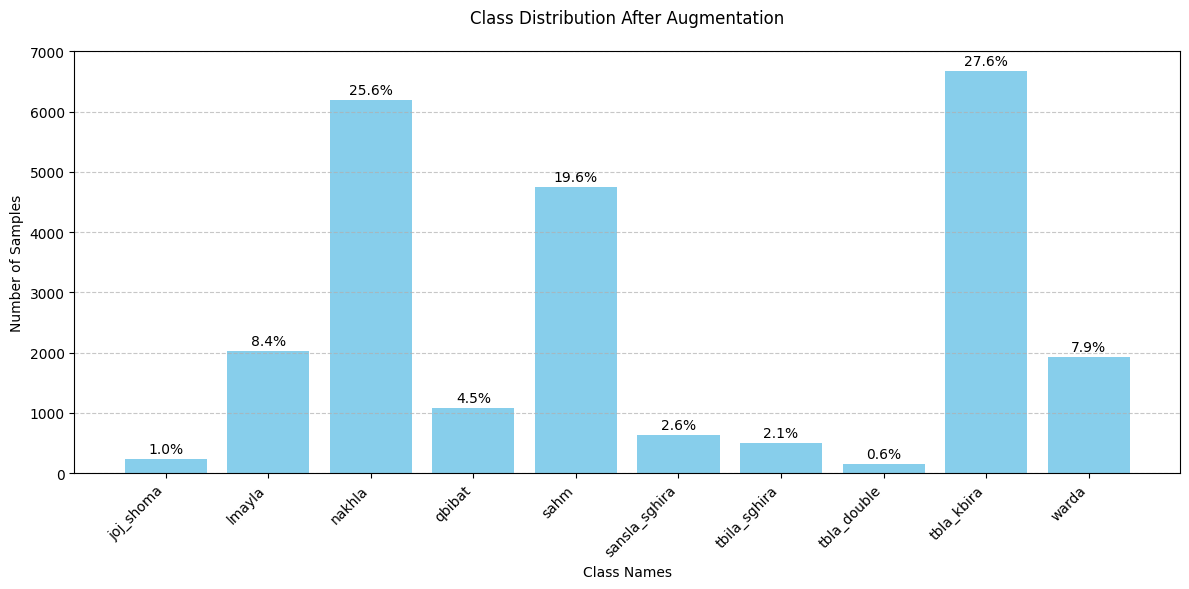

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming y_onehot is your one-hot encoded labels
class_counts = np.sum(y_onehot, axis=0)
classes = label_encoder.classes_  # From your LabelEncoder

# Print exact counts
print("📊 Exact Class Counts:")
for cls, count in zip(classes, class_counts):
    print(f"{cls}: {count} samples ({count/len(y_onehot)*100:.1f}%)")

# Visualization
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.title("Class Distribution After Augmentation", pad=20)
plt.xlabel("Class Names")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels
for i, count in enumerate(class_counts):
    plt.text(i, count+50, f"{count/len(y_onehot)*100:.1f}%",
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Split train test validate

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_balanced_splits(X, y, test_size=0.2, val_size=0.2, random_state=42):

    # Convert one-hot to class indices for stratification
    y_classes = np.argmax(y, axis=1)

    # First split: Separate test set (stratified)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y_classes,
        random_state=random_state
    )

    # Second split: Separate validation from training (stratified)
    y_train_val_classes = np.argmax(y_train_val, axis=1)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size,
        stratify=y_train_val_classes,
        random_state=random_state
    )

    # Verify distributions
    print("\n📊 Final Class Distribution:")
    for name, data in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
        unique, counts = np.unique(np.argmax(data, axis=1), return_counts=True)
        print(f"{name + ':':<12} {dict(zip(unique, counts))}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Usage example:
X_train, X_val, X_test, y_train, y_val, y_test = create_balanced_splits(
    X=X_augmented,
    y=y_onehot,
    test_size=0.2,  # 20% test
    val_size=0.25   # 25% of remaining 80% -> 20% val, 60% train
)


📊 Final Class Distribution:
Train:       {np.int64(0): np.int64(146), np.int64(1): np.int64(1216), np.int64(2): np.int64(3715), np.int64(3): np.int64(648), np.int64(4): np.int64(2849), np.int64(5): np.int64(383), np.int64(6): np.int64(302), np.int64(7): np.int64(89), np.int64(8): np.int64(4005), np.int64(9): np.int64(1152)}
Validation:  {np.int64(0): np.int64(48), np.int64(1): np.int64(406), np.int64(2): np.int64(1239), np.int64(3): np.int64(216), np.int64(4): np.int64(950), np.int64(5): np.int64(128), np.int64(6): np.int64(101), np.int64(7): np.int64(29), np.int64(8): np.int64(1335), np.int64(9): np.int64(384)}
Test:        {np.int64(0): np.int64(49), np.int64(1): np.int64(406), np.int64(2): np.int64(1238), np.int64(3): np.int64(216), np.int64(4): np.int64(950), np.int64(5): np.int64(128), np.int64(6): np.int64(101), np.int64(7): np.int64(29), np.int64(8): np.int64(1335), np.int64(9): np.int64(384)}


In [ ]:
import numpy as np
from datetime import datetime

# Create timestamped directory
save_dir = f"original_splits_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(save_dir, exist_ok=True)

# Save all splits
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)

# Save metadata
metadata = {
    'creation_date': datetime.now().isoformat(),
    'test_size': 0.2,
    'val_size': 0.25,
    'class_distribution': {
        'train': dict(zip(*np.unique(np.argmax(y_train, axis=1), return_counts=True))),
        'val': dict(zip(*np.unique(np.argmax(y_val, axis=1), return_counts=True))),
        'test': dict(zip(*np.unique(np.argmax(y_test, axis=1), return_counts=True)))
    }
}

np.save(os.path.join(save_dir, 'metadata.npy'), metadata)
print(f"✅ Saved original splits to {save_dir}")

✅ Saved original splits to original_splits_20250528_130729


# Data Balancing

In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import os

# 1. Load your original splits using the correct path
split_path = "/content/original_splits_20250528_130729"
splits = {
    'X_train': np.load(os.path.join(split_path, 'X_train.npy')),
    'y_train': np.load(os.path.join(split_path, 'y_train.npy')),
    'X_val': np.load(os.path.join(split_path, 'X_val.npy')),
    'y_val': np.load(os.path.join(split_path, 'y_val.npy')),
    'X_test': np.load(os.path.join(split_path, 'X_test.npy')),
    'y_test': np.load(os.path.join(split_path, 'y_test.npy'))
}

# 2. Verify files loaded correctly
print("✅ Successfully loaded splits from:", split_path)
print(f"X_train shape: {splits['X_train'].shape}")
print(f"y_train shape: {splits['y_train'].shape}")

# 3. Convert one-hot to class indices for balancing
y_train_classes = np.argmax(splits['y_train'], axis=1)
class_names = {
    0: "joj_shoma", 1: "lmayla", 2: "nakhla", 3: "qbibat",
    4: "sahm", 5: "sansla_sghira", 6: "tbila_sghira",
    7: "tbla_double", 8: "tbla_kbira", 9: "warda"
}

# 4. Print original distribution
print("\nOriginal Class Distribution:")
for cls, count in sorted(Counter(y_train_classes).items()):
    print(f"{class_names[cls]}: {count} samples")

# 5. Define target class distribution
target_dist = {
    0: 1000,  # joj_shoma (boost from ~146)
    1: 1500,  # lmayla
    2: 2000,  # nakhla
    3: 1000,  # qbibat
    4: 2000,  # sahm
    5: 1000,  # sansla_sghira
    6: 1000,  # tbila_sghira
    7: 1000,  # tbla_double (boost from ~89)
    8: 2000,  # tbla_kbira (reduce from ~4005)
    9: 1500   # warda
}

# 6. Create balancing pipeline
resampler = Pipeline([
    ('oversample', SMOTE(
        sampling_strategy={k: min(v, 5000) for k,v in target_dist.items()
                         if v > Counter(y_train_classes)[k]},
        k_neighbors=3,
        random_state=42
    )),
    ('undersample', RandomUnderSampler(
        sampling_strategy={k: v for k,v in target_dist.items()
                         if v < Counter(y_train_classes)[k]},
        random_state=42
    ))
])

# 7. Reshape X_train for SMOTE (flatten time steps)
n_samples, timesteps, features = splits['X_train'].shape
X_reshaped = splits['X_train'].reshape(n_samples, -1)

# 8. Apply balancing
X_balanced, y_balanced = resampler.fit_resample(X_reshaped, y_train_classes)

# 9. Restore original shape
X_balanced = X_balanced.reshape(-1, timesteps, features)
y_balanced = np.eye(len(target_dist))[y_balanced]  # Back to one-hot

# 10. Verify new distribution
print("\n✅ Balanced Class Distribution:")
balanced_counts = Counter(np.argmax(y_balanced, axis=1))
for cls, count in sorted(balanced_counts.items()):
    print(f"{class_names[cls]}: {count} samples")

# 11. Save balanced data
balanced_dir = "/content/balanced_data"
os.makedirs(balanced_dir, exist_ok=True)

np.save(os.path.join(balanced_dir, 'X_train_balanced.npy'), X_balanced)
np.save(os.path.join(balanced_dir, 'y_train_balanced.npy'), y_balanced)

# Keep original validation and test sets
np.save(os.path.join(balanced_dir, 'X_val.npy'), splits['X_val'])
np.save(os.path.join(balanced_dir, 'y_val.npy'), splits['y_val'])
np.save(os.path.join(balanced_dir, 'X_test.npy'), splits['X_test'])
np.save(os.path.join(balanced_dir, 'y_test.npy'), splits['y_test'])

print(f"\n💾 Saved balanced data to {balanced_dir}/")

✅ Successfully loaded splits from: /content/original_splits_20250528_130729
X_train shape: (14505, 35, 63)
y_train shape: (14505, 10)

Original Class Distribution:
joj_shoma: 146 samples
lmayla: 1216 samples
nakhla: 3715 samples
qbibat: 648 samples
sahm: 2849 samples
sansla_sghira: 383 samples
tbila_sghira: 302 samples
tbla_double: 89 samples
tbla_kbira: 4005 samples
warda: 1152 samples

✅ Balanced Class Distribution:
joj_shoma: 1000 samples
lmayla: 1500 samples
nakhla: 2000 samples
qbibat: 1000 samples
sahm: 2000 samples
sansla_sghira: 1000 samples
tbila_sghira: 1000 samples
tbla_double: 1000 samples
tbla_kbira: 2000 samples
warda: 1500 samples

💾 Saved balanced data to /content/balanced_data/


In [ ]:
# Test loading one file
test_load = np.load('/content/balanced_data/X_train_balanced.npy')
print(f"Balanced data loaded successfully. Shape: {test_load.shape}")

Balanced data loaded successfully. Shape: (14000, 35, 63)


In [ ]:
# Test loading one file
test_load = np.load('/content/balanced_data/y_train_balanced.npy')
print(f"Balanced data loaded successfully. Shape: {test_load.shape}")

Balanced data loaded successfully. Shape: (14000, 10)


In [ ]:
import json
import numpy as np

def save_metadata(balanced_dir, splits, X_balanced, y_balanced, target_dist):
    # Get class distributions
    original_dist = dict(zip(*np.unique(np.argmax(splits['y_train'], axis=1), return_counts=True)))
    balanced_dist = dict(zip(*np.unique(np.argmax(y_balanced, axis=1), return_counts=True)))

    # Prepare metadata
    metadata = {
        "data_shapes": {
            "original_train": splits['X_train'].shape,
            "balanced_train": X_balanced.shape,
            "validation": splits['X_val'].shape,
            "test": splits['X_test'].shape
        },
        "class_counts": {
            "original": {int(k): int(v) for k, v in original_dist.items()},
            "balanced": {int(k): int(v) for k, v in balanced_dist.items()}
        },
        "processing": {
            "split_ratios": {
                "test_size": 0.2,
                "val_size": 0.25
            },
            "balancing": {
                "method": "SMOTE + RandomUnderSampler",
                "target_counts": {int(k): int(v) for k, v in target_dist.items()}
            }
        }
    }

    # Convert numpy types to native Python types
    def convert_types(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, tuple):
            return list(obj)
        elif isinstance(obj, dict):
            return {convert_types(k): convert_types(v) for k, v in obj.items()}
        return obj

    # Save metadata
    with open(os.path.join(balanced_dir, 'metadata.json'), 'w') as f:
        json.dump(convert_types(metadata), f, indent=2)

    print(f"✅ Metadata successfully saved to {os.path.join(balanced_dir, 'metadata.json')}")

# Usage:
save_metadata(balanced_dir, splits, X_balanced, y_balanced, target_dist)

✅ Metadata successfully saved to /content/balanced_data/metadata.json


# Model Trainning

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 33, 64)         │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 33, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,690 (873.79 KB)

 Trainable params: 223,178 (871.79 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7255 - loss: 1.0444 - precision: 0.8217 - recall: 0.6241

438/438 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7258 - loss: 1.0436 - precision: 0.8218 - recall: 0.6245 - val_accuracy: 0.7268 - val_loss: 0.8663 - val_precision: 0.7422 - val_recall: 0.7109 - learning_rate: 0.0010
Epoch 2/50
436/438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9408 - loss: 0.3922 - precision: 0.9512 - recall: 0.9317

438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9408 - loss: 0.3921 - precision: 0.9512 - recall: 0.9318 - val_accuracy: 0.9551 - val_loss: 0.3445 - val_precision: 0.9562 - val_recall: 0.9533 - learning_rate: 0.0010
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9601 - loss: 0.3132 - precision: 0.9651 - recall: 0.9564

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9601 - loss: 0.3132 - precision: 0.9651 - recall: 0.9564 - val_accuracy: 0.9711 - val_loss: 0.2722 - val_precision: 0.9734 - val_recall: 0.9679 - learning_rate: 0.0010
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9694 - loss: 0.2628 - precision: 0.9729 - recall: 0.9668 - val_accuracy: 0.9603 - val_loss: 0.2844 - val_precision: 0.9614 - val_recall: 0.9580 - learning_rate: 0.0010
Epoch 5/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9768 - loss: 0.2313 - precision: 0.9795 - recall: 0.9746

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9768 - loss: 0.2313 - precision: 0.9795 - recall: 0.9745 - val_accuracy: 0.9810 - val_loss: 0.2142 - val_precision: 0.9816 - val_recall: 0.9806 - learning_rate: 0.0010
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9803 - loss: 0.2092 - precision: 0.9830 - recall: 0.9788 - val_accuracy: 0.9663 - val_loss: 0.2519 - val_precision: 0.9694 - val_recall: 0.9640 - learning_rate: 0.0010
Epoch 7/50
435/438 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9808 - loss: 0.2049 - precision: 0.9830 - recall: 0.9780

438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9808 - loss: 0.2049 - precision: 0.9830 - recall: 0.9780 - val_accuracy: 0.9849 - val_loss: 0.1781 - val_precision: 0.9853 - val_recall: 0.9843 - learning_rate: 0.0010
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9825 - loss: 0.1859 - precision: 0.9839 - recall: 0.9810 - val_accuracy: 0.9812 - val_loss: 0.1752 - val_precision: 0.9820 - val_recall: 0.9801 - learning_rate: 0.0010
Epoch 9/50
436/438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9806 - loss: 0.1803 - precision: 0.9821 - recall: 0.9798

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9806 - loss: 0.1803 - precision: 0.9821 - recall: 0.9798 - val_accuracy: 0.9870 - val_loss: 0.1629 - val_precision: 0.9880 - val_recall: 0.9866 - learning_rate: 0.0010
Epoch 10/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9861 - loss: 0.1658 - precision: 0.9872 - recall: 0.9845 - val_accuracy: 0.9721 - val_loss: 0.1982 - val_precision: 0.9735 - val_recall: 0.9711 - learning_rate: 0.0010
Epoch 11/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9875 - loss: 0.1518 - precision: 0.9881 - recall: 0.9866 - val_accuracy: 0.9686 - val_loss: 0.2204 - val_precision: 0.9711 - val_recall: 0.9669 - learning_rate: 0.0010
Epoch 12/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9825 - loss: 0.1659 - precision: 0.9834 - recall: 0.9814 - val_accuracy: 0.9642 - val_loss: 0.2300 - val_precision: 0.9670 - val_recall: 0.9622 - learning_rate: 0.0010
Epoch 13/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy:

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9917 - loss: 0.1319 - precision: 0.9921 - recall: 0.9911 - val_accuracy: 0.9952 - val_loss: 0.1091 - val_precision: 0.9954 - val_recall: 0.9952 - learning_rate: 5.0000e-04
Epoch 16/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9963 - loss: 0.1030 - precision: 0.9965 - recall: 0.9955 - val_accuracy: 0.9913 - val_loss: 0.1134 - val_precision: 0.9915 - val_recall: 0.9911 - learning_rate: 5.0000e-04
Epoch 17/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9937 - loss: 0.1070 - precision: 0.9938 - recall: 0.9936 - val_accuracy: 0.9940 - val_loss: 0.1055 - val_precision: 0.9942 - val_recall: 0.9936 - learning_rate: 5.0000e-04
Epoch 18/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9927 - loss: 0.1024 - precision: 0.9935 - recall: 0.9925 - val_accuracy: 0.9545 - val_loss: 0.2253 - val_precision: 0.9547 - val_recall: 0.9535 - learning_rate: 5.0000e-04
Epoch 19/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9921 - loss: 0.0881 - precision: 0.9922 - recall: 0.9916 - val_accuracy: 0.9961 - val_loss: 0.0723 - val_precision: 0.9963 - val_recall: 0.9961 - learning_rate: 5.0000e-04
Epoch 29/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9951 - loss: 0.0740 - precision: 0.9951 - recall: 0.9948 - val_accuracy: 0.9928 - val_loss: 0.0854 - val_precision: 0.9928 - val_recall: 0.9928 - learning_rate: 5.0000e-04
Epoch 30/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9964 - loss: 0.0658 - precision: 0.9965 - recall: 0.9963 - val_accuracy: 0.9901 - val_loss: 0.0942 - val_precision: 0.9907 - val_recall: 0.9901 - learning_rate: 5.0000e-04
Epoch 31/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9946 - loss: 0.0729 - precision: 0.9948 - recall: 0.9942 - val_accuracy: 0.9917 - val_loss: 0.0907 - val_precision: 0.9923 - val_recall: 0.9917 - learning_rate: 5.0000e-04
Epoch 32/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9960 - loss: 0.0642 - precision: 0.9962 - recall: 0.9957 - val_accuracy: 0.9967 - val_loss: 0.0610 - val_precision: 0.9967 - val_recall: 0.9965 - learning_rate: 2.5000e-04
Epoch 39/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9979 - loss: 0.0559 - precision: 0.9979 - recall: 0.9979 - val_accuracy: 0.9961 - val_loss: 0.0683 - val_precision: 0.9961 - val_recall: 0.9959 - learning_rate: 2.5000e-04
Epoch 40/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9978 - loss: 0.0539 - precision: 0.9979 - recall: 0.9977 - val_accuracy: 0.9930 - val_loss: 0.0752 - val_precision: 0.9930 - val_recall: 0.9930 - learning_rate: 2.5000e-04
Epoch 41/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9982 - loss: 0.0502 - precision: 0.9982 - recall: 0.9982 - val_accuracy: 0.9955 - val_loss: 0.0613 - val_precision: 0.9955 - val_recall: 0.9955 - learning_rate: 2.5000e-04
Epoch 42/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms

438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9995 - loss: 0.0390 - precision: 0.9995 - recall: 0.9995 - val_accuracy: 0.9973 - val_loss: 0.0521 - val_precision: 0.9973 - val_recall: 0.9971 - learning_rate: 1.2500e-04
Epoch 47/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9992 - loss: 0.0388 - precision: 0.9992 - recall: 0.9990 - val_accuracy: 0.9967 - val_loss: 0.0508 - val_precision: 0.9967 - val_recall: 0.9967 - learning_rate: 1.2500e-04
Epoch 48/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9986 - loss: 0.0382 - precision: 0.9987 - recall: 0.9986 - val_accuracy: 0.9952 - val_loss: 0.0585 - val_precision: 0.9952 - val_recall: 0.9952 - learning_rate: 1.2500e-04
Epoch 49/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9995 - loss: 0.0383 - precision: 0.9995 - recall: 0.9993 - val_accuracy: 0.9967 - val_loss: 0.0468 - val_precision: 0.9967 - val_recall: 0.9967 - learning_rate: 1.2500e-04
Epoch 50/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms

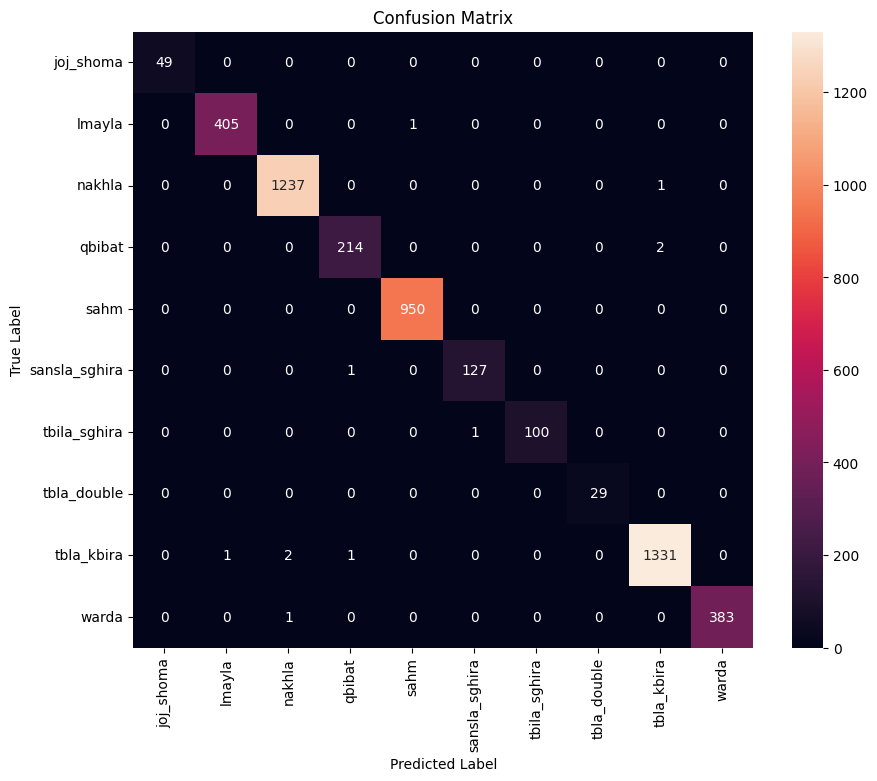


Test F1 Score (Macro): 0.9969


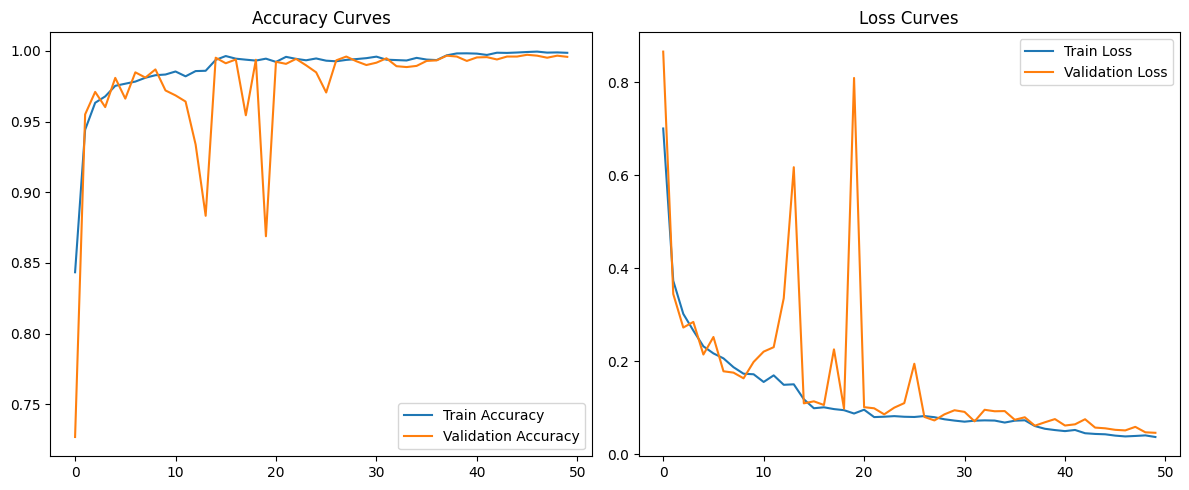

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Model Architecture
def create_optimized_model(input_shape, num_classes):
    model = Sequential([
        # CNN Block 1
        Conv1D(64, kernel_size=3, activation='relu',
               kernel_regularizer=l2(0.001),
               input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # CNN Block 2
        Conv1D(128, kernel_size=3, activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # LSTM Block
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.3),

        # Classifier
        Dense(64, activation='relu',
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    return model

# 2. Load Data
X_train = np.load('/content/balanced_data/X_train_balanced.npy')
y_train = np.load('/content/balanced_data/y_train_balanced.npy')
X_val = np.load('/content/balanced_data/X_val.npy')
y_val = np.load('/content/balanced_data/y_val.npy')
X_test = np.load('/content/balanced_data/X_test.npy')
y_test = np.load('/content/balanced_data/y_test.npy')

# 3. Training Setup
model = create_optimized_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=y_train.shape[1]
)
model.summary()

callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, min_delta=0.001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_gesture_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 4. Evaluation
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    class_names = [
        "joj_shoma", "lmayla", "nakhla", "qbibat", "sahm",
        "sansla_sghira", "tbila_sghira", "tbla_double", "tbla_kbira", "warda"
    ]

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

    # Confusion matrix
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred_classes, average='macro')
    print(f"\nTest F1 Score (Macro): {f1:.4f}")

# Run evaluation
evaluate_model(model, X_test, y_test)

# 5. Plot Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Model accuracy testing

unique prediction

In [ ]:
unique_preds = len(np.unique(model.predict(X_test, verbose=0).argmax(axis=1)))
print(f"Unique predictions: {unique_preds}/{len(y_test)}")

Unique predictions: 10/4836


Duplicate

In [ ]:
# Check for duplicate samples
from sklearn.metrics import pairwise_distances

# For sequences
duplicate_threshold = 1e-6
X_test_flat = X_test.reshape(X_test.shape[0], -1)
distances = pairwise_distances(X_test_flat)
np.fill_diagonal(distances, np.inf)
print(f"Near-duplicate test samples: {np.any(distances < duplicate_threshold)}")

# For labels
unique_labels = np.unique(y_test.argmax(axis=1), return_counts=True)
print("Class distribution in test set:", dict(zip(unique_labels[0], unique_labels[1])))

Near-duplicate test samples: False
Class distribution in test set: {np.int64(0): np.int64(49), np.int64(1): np.int64(406), np.int64(2): np.int64(1238), np.int64(3): np.int64(216), np.int64(4): np.int64(950), np.int64(5): np.int64(128), np.int64(6): np.int64(101), np.int64(7): np.int64(29), np.int64(8): np.int64(1335), np.int64(9): np.int64(384)}


compare to to noisy model

In [ ]:
# Add small noise to test samples
noise_scale = 0.01  # Adjust based on your feature scale
X_test_noisy = X_test + noise_scale * np.random.normal(size=X_test.shape)

# Compare predictions
clean_preds = model.predict(X_test).argmax(axis=1)
noisy_preds = model.predict(X_test_noisy).argmax(axis=1)
change_rate = np.mean(clean_preds != noisy_preds)
print(f"Prediction change rate with noise: {change_rate:.2%}")

# Should typically be <5% for robust models

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Prediction change rate with noise: 0.02%


In [ ]:
# Compare against simple baseline
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf.fit(X_train_flat, y_train.argmax(axis=1))
rf_acc = rf.score(X_test_flat, y_test.argmax(axis=1))
print(f"Random Forest baseline accuracy: {rf_acc:.2%}")

# Your model should significantly outperform this

Random Forest baseline accuracy: 94.79%


overlamping samples


In [ ]:
# Check for overlapping samples between train/test
from sklearn.metrics import pairwise_distances

train_flat = X_train.reshape(X_train.shape[0], -1)
test_flat = X_test.reshape(X_test.shape[0], -1)

# Calculate nearest neighbors between train and test
distances = pairwise_disatances(test_flat, train_flat)
min_distances = np.min(distances, axis=1)

print(f"Samples with near-identical train neighbors: {(min_distances < 1e-6).sum()}/{len(X_test)}")

Samples with near-identical train neighbors: 0/4836


shuffele

In [ ]:
# Test on shuffled temporal order
X_test_shuffled = np.array([np.random.permutation(x) for x in X_test])
shuffled_acc = model.evaluate(X_test_shuffled, y_test, verbose=0)[1]
print(f"Accuracy on shuffled-time data: {shuffled_acc:.2%}")

# Test on noise
X_test_noisy = X_test + np.random.normal(0, 0.1, size=X_test.shape)
noisy_acc = model.evaluate(X_test_noisy, y_test, verbose=0)[1]
print(f"Accuracy on noisy data: {noisy_acc:.2%}")

Accuracy on shuffled-time data: 96.55%
Accuracy on noisy data: 99.63%


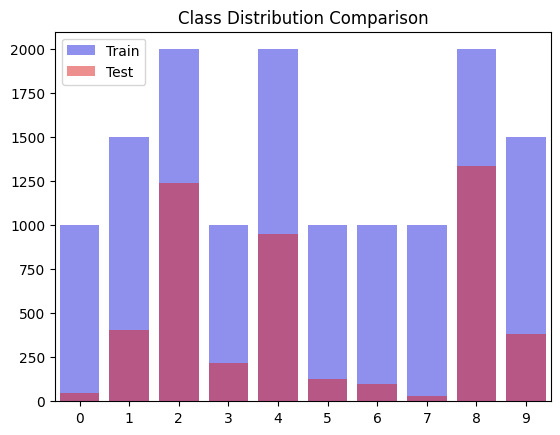

In [ ]:
import seaborn as sns

train_class_dist = np.unique(np.argmax(y_train, axis=1), return_counts=True)
test_class_dist = np.unique(np.argmax(y_test, axis=1), return_counts=True)

sns.barplot(x=train_class_dist[0], y=train_class_dist[1], color='blue', alpha=0.5, label='Train')
sns.barplot(x=test_class_dist[0], y=test_class_dist[1], color='red', alpha=0.5, label='Test')
plt.title("Class Distribution Comparison")
plt.legend()
plt.show()

In [ ]:
# Train a simple model on raw features (no temporal info)
from sklearn.linear_model import LogisticRegression

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_flat, np.argmax(y_train, axis=1))
print(f"Linear model accuracy: {lr.score(X_test_flat, np.argmax(y_test, axis=1)):.2%}")

Linear model accuracy: 91.89%


K- FOLD

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
fold_accuracies = []

for train_idx, val_idx in kf.split(X_train):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

    model.fit(X_fold_train, y_fold_train,
              epochs=10,  # Short training
              validation_data=(X_fold_val, y_fold_val),
              verbose=0)

    acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)[1]
    fold_accuracies.append(acc)

print(f"Cross-val accuracy: {np.mean(fold_accuracies):.2%} ± {np.std(fold_accuracies):.2%}")

Cross-val accuracy: 89.64% ± 8.37%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

# Focus on off-diagonal entries
print("Most common errors:")
for i in range(10):
    for j in range(10):
        if i != j and cm[i,j] > 0:
            print(f"{class_names[i]} → {class_names[j]}: {cm[i,j]} cases")

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Most common errors:
joj_shoma → qbibat: 1 cases
lmayla → nakhla: 1 cases
lmayla → sahm: 4 cases
tbla_double → qbibat: 2 cases
tbla_kbira → lmayla: 2 cases
tbla_kbira → nakhla: 68 cases
tbla_kbira → qbibat: 6 cases
tbla_kbira → sahm: 114 cases
tbla_kbira → tbila_sghira: 1 cases
warda → nakhla: 6 cases
warda → qbibat: 4 cases
warda → sansla_sghira: 1 cases


In [ ]:
# Correct way to handle multiple metrics
val_metrics = model.evaluate(X_val, y_val)
val_loss = val_metrics[0]
val_accuracy = val_metrics[1]  # Assuming accuracy is the second metric
print(f"Validation set - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9568 - loss: 0.1962 - precision: 0.9620 - recall: 0.9503
Validation set - Loss: 0.1868, Accuracy: 95.82%


In [ ]:
import pickle
from datetime import datetime

# 1. Save the trained model
model.save('gesture_recognition_model.keras')  # Recommended Keras format
# Alternative: model.save('gesture_recognition_model.h5')  # Legacy HDF5 format

In [ ]:
model.save('gesture_recognition_model.h5')

In [ ]:
model.save(r'C:\Users\Lenovo\OneDrive\Bureau\frames\gesture_recognition_model.keras')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/MyDrive/gesture_recognition_model.keras')


Mounted at /content/drive


In [ ]:
# 2. Save the class names for interpretation
class_names = [
    "joj_shoma", "lmayla", "nakhla", "qbibat", "sahm",
    "sansla_sghira", "tbila_sghira", "tbla_double", "tbla_kbira", "warda"
]

with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

# Summary

Le projet **M3lem** est un **jumeau numérique** pour l’apprentissage de la broderie marocaine traditionnelle. Voici comment nous l’avons réalisé :

Pour commencer, nous avons utilisé **OpenMV et Mediapipe** pour capturer les gestes des artisans. Chaque geste a été transformé en **séquences de frames**, chaque frame représentant les positions des articulations de la main, notamment le poignet et les doigts. Nous avons ensuite **normalisé** ces données pour standardiser la position du poignet et la taille de la main, afin que le modèle ne soit pas influencé par la taille ou l’orientation des mains.

Pour améliorer la qualité des données et éviter le surapprentissage, nous avons fait de l’**augmentation de données**, en générant des variations légères des séquences, et nous avons veillé à avoir des **classes équilibrées**. Les classes ont été encodées en **one-hot vectors** pour le modèle, et les noms de classes en **entiers via LabelEncoder**. Nous avons ensuite **séparé les données en train, test et validation**, en stratifiant pour maintenir la proportion de chaque classe. Pour gérer les classes déséquilibrées, nous avons utilisé **SMOTE** pour augmenter artificiellement les classes trop petites et un **random undersampler** pour réduire les classes trop grandes.

Pour le modèle, nous avons utilisé une **architecture séquentielle** :

* **Conv1D(64)** avec activation ReLU, régularisation L2, suivi de **BatchNormalization** et **MaxPooling** pour extraire les motifs locaux et réduire la dimension temporelle.
* **Conv1D(128)** avec les mêmes techniques pour capturer des motifs plus complexes.
* Ensuite, **LSTM(128, return_sequences=True)** pour capturer les dépendances temporelles longues dans les séquences.
* Puis **LSTM(64)** pour résumer la séquence entière en un vecteur de caractéristiques plus compact.
* Enfin, une couche **Dense(64, ReLU)** suivie de **BatchNormalization**, puis une **Dense(num_classes, softmax)** pour obtenir les probabilités de chaque type de point de broderie.

Après l’entraînement, nous avons évalué le modèle sur le jeu de test, vérifié que toutes les classes étaient prédites (**unique predictions = 10/10**), testé la robustesse en ajoutant du **bruit** ou en mélangeant l’ordre des frames, et comparé avec des modèles baselines comme **Random Forest** ou **Logistic Regression**.

Enfin, nous avons intégré le tout dans **Unreal Engine** avec un **MetaHuman** créé dans Blender. Le personnage reproduit les gestes reconnus par l’IA, offrant une expérience immersive pour apprendre la broderie de façon digitale.

Ce projet combine **capture de mouvement**, **deep learning pour reconnaissance de gestes**, et **visualisation 3D interactive**, et il permet de former de nouveaux artisans tout en préservant le savoir-faire traditionnel marocain.
